In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import json
import sqlite3
import networkx as nx
from itertools import cycle

from src.author_mapping.scripts.map_abbreviations_to_authors import map_abbreviations_to_authors

In [45]:
# Your dictionary
static_color_map = {'Altenburg': (), 'Bad-Dueben': (), 'Borna': (), 'Delitzsch': (),
                    'Doebeln': (), 'Eilenburg': (), 'Geithain': (), 'Grimma': (),
                    'Kultur': (), 'Leipzig': (), 'Mitteldeutschland': (), 'Oschatz': (),
                    'Schkeuditz': (), 'Specials': (), 'Sportbuzzer': (), 'Taucha': (),
                    'Wirtschaft': (), 'Wurzen': ()}

# Get a set of distinguishable colors using matplotlib
colors = plt.cm.tab20b.colors

# Create an iterator to cycle through the colors
color_cycle = cycle(colors)

# Assign a color to each key in the dictionary
for key in static_color_map:
    static_color_map[key] = next(color_cycle)

# Print the resulting dictionary with colors
print(static_color_map)

{'Altenburg': (0.2235294117647059, 0.23137254901960785, 0.4745098039215686), 'Bad-Dueben': (0.3215686274509804, 0.32941176470588235, 0.6392156862745098), 'Borna': (0.4196078431372549, 0.43137254901960786, 0.8117647058823529), 'Delitzsch': (0.611764705882353, 0.6196078431372549, 0.8705882352941177), 'Doebeln': (0.38823529411764707, 0.4745098039215686, 0.2235294117647059), 'Eilenburg': (0.5490196078431373, 0.6352941176470588, 0.3215686274509804), 'Geithain': (0.7098039215686275, 0.8117647058823529, 0.4196078431372549), 'Grimma': (0.807843137254902, 0.8588235294117647, 0.611764705882353), 'Kultur': (0.5490196078431373, 0.42745098039215684, 0.19215686274509805), 'Leipzig': (0.7411764705882353, 0.6196078431372549, 0.2235294117647059), 'Mitteldeutschland': (0.9058823529411765, 0.7294117647058823, 0.3215686274509804), 'Oschatz': (0.9058823529411765, 0.796078431372549, 0.5803921568627451), 'Schkeuditz': (0.5176470588235295, 0.23529411764705882, 0.2235294117647059), 'Specials': (0.6784313725490

In [3]:
con = sqlite3.connect('../data/interim/articles_with_author_mapping.db')
cur = con.cursor()

In [32]:
authors, authors_frequency_score, authors_department_score, author_mapping, self_referencing_authors, remaining_abbrs = map_abbreviations_to_authors("../data/interim/articles_with_author_mapping.db")

100%|██████████| 275/275 [00:08<00:00, 33.09it/s]

Found 275 authors with both frequency and department score
Removed 3 self referencing nodes
constructed graph with 526 nodes and 454 edges
calculated new assigned graph with 392 nodes and 182 edges
author_mapping has 182 rows
after dummy removal: author_mapping has 134 rows
There are 28 abbreviations that were not matched
['ast', 'at', 'nie', 'mape', 'ttr', 'mot', 'mabe', 'beck', 'joh', 'ms', 'thomas', 'th', 'haeg', 'ter vehn', 'döring', 'isc', 'grätz', 'sag', 'nag', 'roger', 'kreuz', 'dei', 'sie', 'iro', 'psz', 'cc', 'hem', 'almu']
21 abbreviations have only one edge in the old graph
remaining unmatched abbreviations ['ttr', 'mabe', 'beck', 'joh', 'ms', 'haeg', 'nag']


In [33]:
list(authors.sort_values(by="normalized_score", ascending=True)["abbreviation"].unique())[:70]

['diw',
 'hog',
 'obü',
 'kh',
 'jw',
 'uw',
 'ukö',
 'nn',
 'jv',
 'gs',
 'anzi',
 'ap',
 'jkl',
 'abö',
 'sp',
 'bis',
 'mes',
 'an',
 'cj',
 'lcl',
 'jaf',
 'nhr',
 'ys',
 'cs',
 'cn',
 'sg',
 'jto',
 'tnh',
 'rohe',
 'kub',
 'as',
 'bm',
 'lg',
 'bw',
 'ic',
 'aku',
 'dietze',
 'afs',
 'mpu',
 'mo',
 'mwö',
 'gap',
 'hs',
 'okz',
 'dbr',
 'mey',
 'ra',
 'midi',
 'vag',
 'if',
 'sl',
 'jas',
 'rob',
 'jhz',
 'ar',
 'fd',
 'mhs',
 'tsa',
 'es',
 'sro',
 'hgw',
 'kr',
 'soa',
 'nf',
 'noe',
 'thlang',
 'nqq',
 'fsw',
 'karin',
 'joka']

In [34]:
# chose a set of abbreviations and get corresponding names. Later in the analysis of the ground truth (before the matching), take the same abbreviations 
def prepare(full_names, match_on="name"):    
    json_authors = [json.dumps(author) for author in full_names]
    
    # fetch all articles from these authors
    rows = cur.execute(f"SELECT ar.id, ar.article_namespace_array, ar.published_at, a.name FROM articles ar join article_authors aa on ar.id = aa.article_id join unmapped_authors a on aa.author_id = a.id where a.{match_on} in " + '(' + ','.join(json_authors) + ')').fetchall()
    
    # In the following: determine the department association for those authors
    
    # create department dataframe
    departments = pd.DataFrame(columns=['id', 'department', 'published_at', 'name'], data=rows)
    departments["department"] = departments["department"].apply(lambda x: json.loads(x))
    departments = departments.explode('department')
    
    # remove rows where department equals "Region" or "Nachrichten" for being to unspecific
    departments = departments[departments.department != 'Region']
    departments = departments[departments.department != 'Nachrichten']
    
    # create pandas data frame with author name and their department in that they wrote the most articles
    author_departments = departments.groupby(['name', 'department']).agg('count').sort_values(by='id', ascending=False).reset_index()
    
    # for each author get row with highest count
    author_departments = author_departments.groupby('name').head(1)
    
    # drop column id
    author_departments = author_departments.drop(columns=['id'])
    
    # rename column published_at to article_count
    author_departments = author_departments.rename(columns={'published_at': 'article_count'})
    
    return json_authors, departments, author_departments

In [35]:
def determine_co_authors(json_authors, match_on="name"):
    # in the following, we determine co-authorship
    
    rows = cur.execute(f"SELECT ar.id, a.name FROM articles ar join article_authors aa on ar.id = aa.article_id join unmapped_authors a on aa.author_id = a.id where a.{match_on} in " + '(' + ','.join(json_authors) + ')').fetchall()
    authors_with_articles = pd.DataFrame(columns=['id', 'name'], data=rows)
    
    # remove the rows where the id does not occur in the whole dataframe more than once
    # that means we remove articles that do not have more than one author
    authors_with_articles = authors_with_articles[authors_with_articles.id.isin(authors_with_articles.id.value_counts()[authors_with_articles.id.value_counts() > 1].index)]
    
    return authors_with_articles

## Now we construct the graph

In [36]:
def construct_graph(authors_with_articles, author_departments):
    edges = authors_with_articles.groupby('id')['name'].apply(list).tolist()
    # print len edges
    print(len(edges))
    
    # remove edges with more than 2 names just for the simplicity of the evaluation
    modified_edges = []
    for edge in edges:
        if len(edge) > 2:
            for i in range(len(edge)):
                for j in range(i+1, len(edge)):
                    modified_edges.append([edge[i], edge[j]])
        elif len(edge) < 2: # for some reasons
            continue
        else:
            modified_edges.append(edge)
            
    edges = modified_edges
    
    graph = nx.Graph()
    graph.clear()
    
    # Count the occurrences of each edge
    edge_counts = {}
    for edge in edges:
        key = tuple(sorted(edge))
        edge_counts[key] = edge_counts.get(key, 0) + 1
    
    color_map = []
    
    # Add nodes and weighted edges to the graph
    for edge, count in edge_counts.items():
        node1, node2 = edge
        if count < 5:
            continue
        if not graph.has_node(node1):
            graph.add_node(node1)
            # add a color to the node
            color_map.append(static_color_map[author_departments[author_departments.name == node1].department.values[0]])
        if not graph.has_node(node2):
            graph.add_node(node2)
            # add a color to the node
            color_map.append(static_color_map[author_departments[author_departments.name == node1].department.values[0]])
        graph.add_edge(node1, node2, weight=count)
        
        
    return graph, color_map



728


<Figure size 640x480 with 0 Axes>

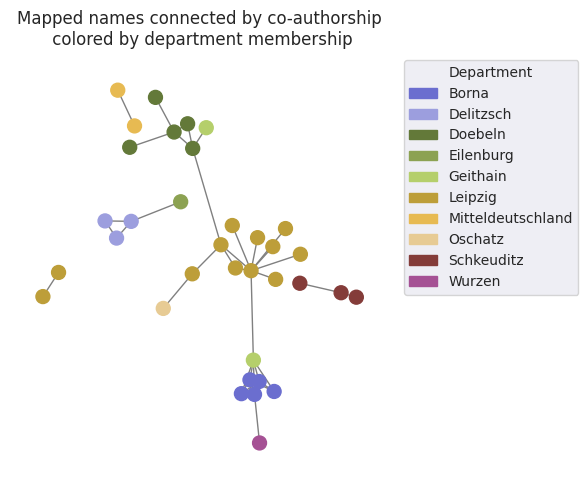

In [46]:

chosen_abbreviations = list(authors.sort_values(by="normalized_score", ascending=True)["abbreviation"].unique())[:70]
full_names = authors[authors["abbreviation"].isin(chosen_abbreviations)]["full_name"].unique()
json_authors, _, author_departments = prepare(full_names)
authors_with_articles = determine_co_authors(json_authors)
graph, color_map = construct_graph(authors_with_articles, author_departments)

plt.clf()
# display graph
plt.figure(figsize=[6,5])
plt.title('Mapped names connected by co-authorship\n colored by department membership')
pos = nx.spring_layout(graph, k=0.6)
nx.draw(graph, pos=pos, node_color=color_map, node_size=100, font_size=6.5, font_weight='bold', edge_color='gray')

# Create a dummy plot for the legend (this won't be visible, but it's necessary to create a legend)
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in static_color_map.items() if color in color_map]

# Specify the position of the legend outside the plot
plt.legend(handles=legend_patches, title='Department', loc='upper left', bbox_to_anchor=(1.02, 1))

# Adjust the layout to make room for the legend
plt.tight_layout()

# Uncomment the line below if you want to save the figure
plt.savefig('../reports/figures/department_exploration/mapped_names_co_authors_department_membership.png', dpi=200)

plt.show()



385


<Figure size 640x480 with 0 Axes>

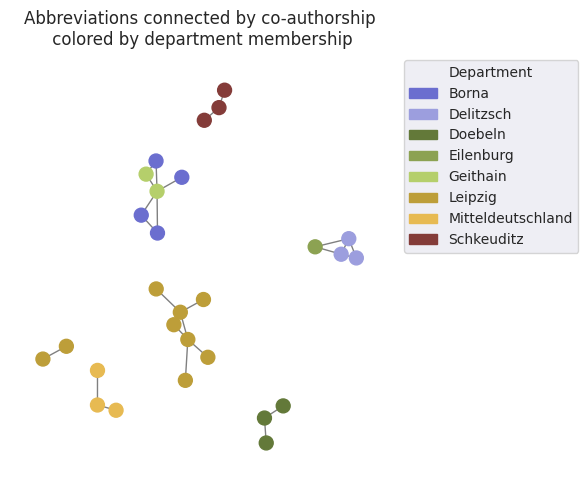

In [47]:
# NOW for "ground truth" aka the set of abbreviations
json_authors, _, author_departments = prepare(chosen_abbreviations, match_on="abbreviation")
authors_with_articles = determine_co_authors(json_authors, match_on="abbreviation")
# remove non values from authors_with_articles
authors_with_articles = authors_with_articles.dropna()
graph, color_map = construct_graph(authors_with_articles, author_departments)

plt.clf()
# display graph
plt.figure(figsize=[6,5])
plt.title('Abbreviations connected by co-authorship\n colored by department membership')
pos = nx.spring_layout(graph, k=0.6)
nx.draw(graph, pos=pos, node_color=color_map, node_size=100, font_size=6.5, font_weight='bold', edge_color='gray')

# Create a dummy plot for the legend (this won't be visible, but it's necessary to create a legend)
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in static_color_map.items() if color in color_map]

# Specify the position of the legend outside the plot
plt.legend(handles=legend_patches, title='Department', loc='upper left', bbox_to_anchor=(1.02, 1))

# Adjust the layout to make room for the legend
plt.tight_layout()

# Uncomment the line below if you want to save the figure
plt.savefig('../reports/figures/department_exploration/abbreviations_co_authors_department_membership.png', dpi=200)

plt.show()

### The following cell plot a general co-authorship graph. It is not connected with the mapping

1086


<Figure size 640x480 with 0 Axes>

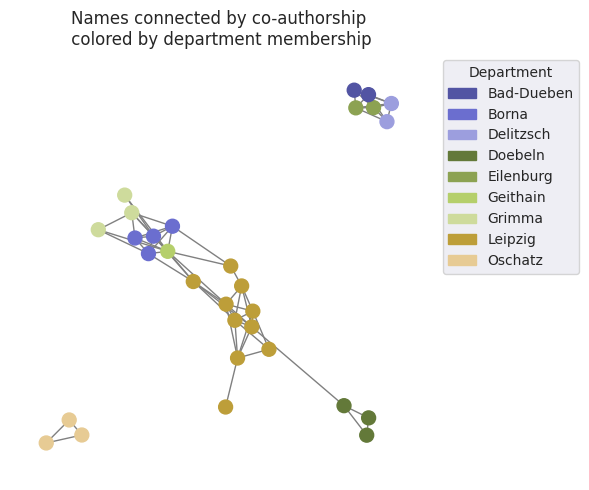

In [48]:
full_names = [name[0] for name in cur.execute("SELECT name FROM unmapped_authors group by name order by count(*) desc limit 40").fetchall()]
json_authors, _, author_departments = prepare(full_names)
authors_with_articles = determine_co_authors(json_authors)
graph, color_map = construct_graph(authors_with_articles, author_departments)

plt.clf()
# display graph
plt.figure(figsize=[6,5])
plt.title('Names connected by co-authorship\n colored by department membership')
pos = nx.spring_layout(graph, k=0.7)
nx.draw(graph, pos=pos, node_color=color_map, node_size=100, font_size=6.5, font_weight='bold', edge_color='gray')

# Create a dummy plot for the legend (this won't be visible, but it's necessary to create a legend)
import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in static_color_map.items() if color in color_map]

# Specify the position of the legend outside the plot
plt.legend(handles=legend_patches, title='Department', loc='upper left', bbox_to_anchor=(1.02, 1))

# Adjust the layout to make room for the legend
plt.tight_layout()

# Uncomment the line below if you want to save the figure
plt.savefig('../reports/figures/department_exploration/names_co_authors_department_membership.png', dpi=200)

plt.show()

